## *<font color = maroon> Notebook 3: </font>* Probability Distribution of Submesoscale Structures in Santa Monica Bay - 
**This script includes the following:** <br> 
1. **Record Location of all Structure**<br>
    - Bins associated with Zodiac data are counted once per track
    - Bins assoicated with structures, front or filament, are counted once per track

2. **Likelihood of Structure Detection** <br>
    - The number of bins where a structure is detected at least one per a track are divided by total number of tracks said bin is traversed through
    - **Provides a probability in terms of likelihood of detecting a structure per cruise, or Zodiac outing**

3. **Plots/Results** <br>
    - Plots of probability are likelihood (%) per bin 
    - All bins with at least one cruise are shown, user may decide to mark cruises of <font color=magenta> significant sampling size </font>

<font color = maroon> **Code is organized based on the three sections defined above, with <font color = magenta> parameter </font> definitions below** </font>

In [1]:
# --------- Edit Code --------- #

# Detection Parameters
window_size = 25      # Multiply by 10 for physical distance (m) of smoothing relative to track
gradient_thresh = 1.0 # in deg. C per KM

# Santa Monica Bay Bounds
lat_min = 33.55
lat_max = 34.15
lon_min = -118.85
lon_max = -118.25
# Consequental partitoning 
bins = 51

# Sample size (more than not equal to)
sig_sample_size = 5

# Treating Data - true means removal (rmv)
rmv_nan = False
rmv_mdr = True

# General Graphing Fontsizes
fs_tick  = 35
fs_label = 30 
fs_title = 40

# Additional plot features #
# depth contours
plot_bath = True
# land detail (purely cosmetic)
plot_land = True
# if either are true set location of data
fname = './crm_socal_1as_vers2.nc'

# Saving options
saveplots = True

#### Employed Libraries

In [2]:
# ----- Libraries ----- #

# Functions
import numpy as np
import statistics
import functions as zf

# Files
import pickle

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
#get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib import colors
import matplotlib as mlb
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, LogNorm, NoNorm
import matplotlib.patches as mpatches
import matplotlib.axes as AX
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from matplotlib.axes import inset_axes

# Mapping
import cartopy
import cartopy.crs as ccrs #importing the cartopy coordinate reference system library
import cartopy.feature as cfeature #importing the cartopy library of surface features
import cartopy.io.shapereader as shpreader

# Smoothing
import scipy.io as sio
import scipy.stats as ss
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import peak_prominences

# ----- IMPORT Track dictionary as pkl ----- #
with open('track_data.pkl', 'rb') as ztd:
    zodiac_track_data = pickle.load(ztd)
# ----- IMPORT Ensemble dictionaries as pkl ----- #
# Read dictionary pkl file
with open('filament_ensemble.pkl', 'rb') as ztd:
    filament_ensemble = pickle.load(ztd)
with open('front_ensemble.pkl', 'rb') as ztd:
    front_ensemble = pickle.load(ztd)

In [3]:
# Grab socal coastal relief data if user specifies
if plot_land or plot_bath:
    from netCDF4 import Dataset, num2date
    nc = Dataset(fname)

    # Adjust resolution to improve run time
    res = 2

    lon_relief, lat_relief = np.array(nc.variables['lon'][::res]), np.array(nc.variables['lat'][::res])
    depths = np.array(nc.variables['Band1'][::res, ::res])

    lon_low = np.where((lon_relief <= -118.25) & (lon_relief > -118.85))[0][-1]
    lon_upp = np.where((lon_relief <= -118.25) & (lon_relief > -118.85))[0][0]
    lat_low = np.where((lat_relief >= 33.5) & (lat_relief < 34.15))[0][0]
    lat_upp = np.where((lat_relief >= 33.5) & (lat_relief < 34.15))[0][-1]

    depths = depths[lat_low:lat_upp, lon_upp:lon_low]

    lon_relief = lon_relief[lon_upp:lon_low]
    lat_relief = lat_relief[lat_low:lat_upp]

    lon_relief, lat_relief = np.meshgrid(lon_relief, lat_relief)

### 1. Zodiac/Structure Location

In [4]:
# ----- Generate PDF ----- #
total_trips = []

row_count, col_count = [], []
row_str,   col_str   = [], []

rows = np.linspace(lat_min, lat_max, bins)
cols = np.linspace(lon_min, lon_max, bins)

# Structure Specific
fro_row, fro_col = [], []
fil_row, fil_col = [], []

# LOOP 1: For each possible date load in data
for index, date in enumerate(zodiac_track_data):
    try:
        lat, lon, SST, flu = zf.select_track(date, zodiac_track_data, excludenans=rmv_nan, excludemdr=rmv_mdr)

        # 1.1: process data onto uniform grid and perform running average on SST data
        dist_processed, sst_processed = zf.data_processing(lat, lon, SST, 10)
        grad_dist_sst, grad_sst, lat_sst, lon_sst, sst_filtered, dist_filtered = \
        zf.running_avg_filter(window_size, lat, lon, sst_processed, dist_processed)

        # LOOP 2: Slice the data up by latitude - i.e. select row
        for j in range(len(rows) - 1):
            lower_lim_row = rows[j]
            upper_lim_row = rows[j + 1]
            row_bounds    = (lat_sst >= lower_lim_row) & (lat_sst < upper_lim_row)

            # 2.1: Grab all data in row
            row_latitude  = lat_sst[row_bounds]
            row_longitude = lon_sst[row_bounds]
            row_distance  = dist_filtered[row_bounds]
            row_sst       = sst_filtered[row_bounds]

            # LOOP 3: Slice the data by longiude
            for i in range(len(cols) - 1):
                lower_lim_col = cols[i]
                upper_lim_col = cols[i + 1]
                # Already adjusted longitude so this gives the data in a bin
                bin_bounds    = (row_longitude >= lower_lim_col) & (row_longitude < upper_lim_col)

                # 3.1: Grab all data in bin
                bin_distance  = row_distance[bin_bounds]
                bin_sst       = row_sst[bin_bounds]
                # bin position...
                row_position = .5*(lower_lim_row + upper_lim_row)
                col_position = .5*(lower_lim_col + upper_lim_col)

                # 3.2: Grab all SST structures (fronts & filaments)
                for fil in range(len(filament_ensemble)):
                     if filament_ensemble[fil+1]['Date'] == date:
                        x=filament_ensemble[fil+1]['Min-Lon']
                        y=filament_ensemble[fil+1]['Min-Lat']
                        if ((x >= lower_lim_col) & (x < upper_lim_col)) and ((y >= lower_lim_row) & (y < upper_lim_row)):
                            row_str.append(row_position)
                            col_str.append(col_position)
                            # Add filaments
                            fil_row.append(row_position)
                            fil_col.append(col_position)

                for fro in range(len(front_ensemble)):
                    if filament_ensemble[fil+1]['Date'] == date:
                        x=front_ensemble[fro+1]['Max-Lon']
                        y=front_ensemble[fro+1]['Max-Lat']
                        if ((x >= lower_lim_col) & (x < upper_lim_col)) and ((y >= lower_lim_row) & (y < upper_lim_row)):
                            row_str.append(row_position)
                            col_str.append(col_position)
                            # Add fronts 
                            fro_row.append(row_position)
                            fro_col.append(col_position)

                # 3.3: record if zodiac was in bin
                if len(bin_distance) > 0:
                    row_count.append(row_position)
                    col_count.append(col_position)

        total_trips = np.append(total_trips, date)
        
    except:
        pass
    continue

### 2. Likelihood of Detection

In [5]:
# ----- Likelihood of Detection ----- #
bin_likelihood_lat = []
bin_likelihood_lon = []

fro_perc_lat, fro_perc_lon = [], []
fil_perc_lat, fil_perc_lon = [], []

verified_lat = []
verified_lon = []

mask_lat = []
mask_lon = []

all_lats = np.unique(row_count)
all_lons = np.unique(col_count)

for j in range(len(all_lats)):
    y_j = all_lats[j]
    for i in range(len(all_lons)):
        x_i = all_lons[i]
        
        general_total   = len(np.where((col_count == x_i) & (row_count == y_j))[0])
        structure_total = len(np.where((col_str == x_i) & (row_str == y_j))[0])
        front_total     = len(np.where((fro_col == x_i) & (fro_row == y_j))[0])
        filament_total  = len(np.where((fil_col == x_i) & (fil_row == y_j))[0])

        if general_total != 0:
            bin_percentage  = (structure_total/general_total)*100
            fro_percentage  = (front_total/general_total)*100
            fil_percentage  = (filament_total/general_total)*100

            bin_likelihood_lat = np.append(bin_likelihood_lat, np.repeat(y_j, bin_percentage))
            bin_likelihood_lon = np.append(bin_likelihood_lon, np.repeat(x_i, bin_percentage))
            
            fro_perc_lat       = np.append(fro_perc_lat, np.repeat(y_j, fro_percentage))
            fro_perc_lon       = np.append(fro_perc_lon, np.repeat(x_i, fro_percentage))
            
            fil_perc_lat       = np.append(fil_perc_lat, np.repeat(y_j, fil_percentage))
            fil_perc_lon       = np.append(fil_perc_lon, np.repeat(x_i, fil_percentage))

            if (general_total > sig_sample_size):
                verified_lat   = np.append(verified_lat, y_j)
                verified_lon   = np.append(verified_lon, x_i)
            
                if (bin_percentage == 0) or (fil_percentage == 0) or (fro_percentage == 0):
                    mask_lat = np.append(mask_lat, y_j)
                    mask_lon = np.append(mask_lon, x_i)

### 3. Probability Distribution

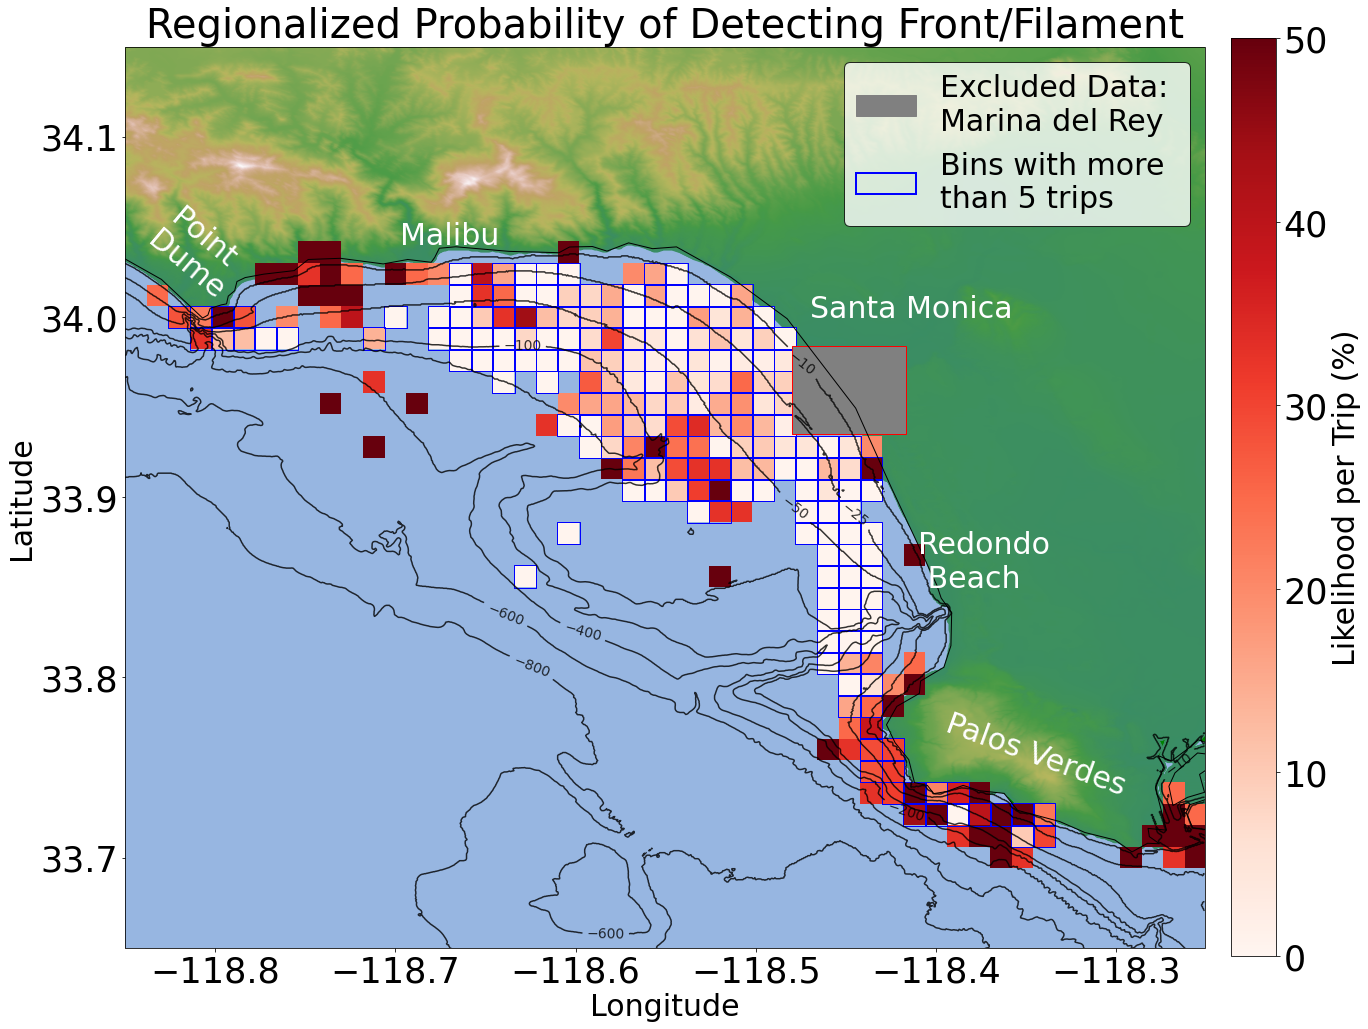

In [6]:
fig1 = plt.figure(1, (20,15))
long_lat_cords = [lon_min, lon_max, lat_min, lat_max]
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(long_lat_cords) # Will restrict map to above coordinate domain
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor = 'green')
ax.add_feature(cfeature.OCEAN)

# Add details 
if plot_bath:
    cs = plt.contour(lon_relief, lat_relief, depths, [-800, -600, -400, -200, -100, -50, -25, -10], cmap='gray', vmin=-10, alpha = .8)
    plt.clabel(cs, inline = True, fontsize = 14)

if plot_land:
    terra = plt.scatter(lon_relief[depths > 0], lat_relief[depths > 0], c = depths[depths > 0], cmap = 'gist_earth', vmin = 10)
    terra.set_clim(-500)

plt.hist2d(mask_lon, mask_lat, bins=(50,50),
           range = [(lon_min, lon_max), (lat_min, lat_max)],
           cmap=cm.Reds, cmin = 1, vmin = 0, vmax = 100, zorder=1)

plt.hist2d(bin_likelihood_lon, bin_likelihood_lat, bins=(50,50),
           range = [(lon_min, lon_max), (lat_min, lat_max)],
           cmap=cm.Reds, cmin = 1, vmin = 0, vmax = 50, zorder=1)

cbar = plt.colorbar(shrink = .93, pad = 0.02)
cbar.set_label('Likelihood per Trip (%)', fontsize = fs_label)
cbar.ax.tick_params(labelsize = fs_tick)

plt.scatter(verified_lon, verified_lat, s = 500, marker = 's', facecolor='none', edgecolor='blue')

if rmv_mdr == True:
    vertices = [-118.48, -118.417, 33.983902, 33.935]
    x_origin, y_origin = vertices[0], vertices[2]
    x_distance, y_distance = (vertices[1] - vertices[0]), (vertices[3] - vertices[2])
    rectangle = mpatches.Rectangle((x_origin, y_origin), x_distance, y_distance, fc='grey',ec="red")
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')
    
# Add locations
plt.text(-118.81, 34.01, 'Point \nDume', fontsize=fs_label, rotation=-40, ha='center', color = 'white')
plt.text(-118.67, 34.04, 'Malibu', fontsize=fs_label, rotation=0, ha='center', color = 'white')
plt.text(-118.47, 34.0,  'Santa Monica', fontsize=fs_label, rotation=  0, ha='left',   color = 'white')
plt.text(-118.41, 33.85,  'Redondo \n Beach', fontsize=fs_label, rotation=0, ha='left',color = 'white')
plt.text(-118.345, 33.735, 'Palos Verdes', fontsize=fs_label, rotation=-20, ha='center', color = 'white')
    
# legend 
gray_patch = mpatches.Patch(color='gray', label='Excluded Data: \nMarina del Rey')
legend_square = mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='blue', lw=2, label='Bins with more \nthan 5 trips')
legend = plt.legend(handles=[gray_patch, legend_square], loc='upper right', fontsize = fs_label, frameon = True)
frame = legend.get_frame()
frame.set_linewidth(1)        # Border thickness
frame.set_facecolor('white')  # Background color
frame.set_edgecolor('black')
    
# Adjust bounds
ax.set_ylim(33.65, lat_max)

# Graping params
ax.set_xticks(np.linspace(-118.80, -118.30, 6)) # set x-ticks
ax.set_xlabel('Longitude', fontsize = fs_label)
ax.set_yticks(np.linspace(33.7, 34.10, 5))      # set y-ticks
ax.set_ylabel('Latitude', fontsize = fs_label)
ax.set_title('Regionalized Probability of Detecting Front/Filament', fontsize = fs_title)

# Adjust tick size
ax.tick_params(axis='both', labelsize=fs_tick)

plt.tight_layout()

if saveplots == True:
    plt.savefig('likelihood_plot.png')

In [7]:
if not rmv_mdr:
    fig2 = plt.figure(1, (20,15))
    long_lat_cords = [lon_min, lon_max, lat_min, lat_max]
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(long_lat_cords) # Will restrict map to above coordinate domain
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor = 'green')
    ax.add_feature(cfeature.OCEAN)

    # Add details 
    if plot_bath:
        cs = plt.contour(lon_relief, lat_relief, depths, [-800, -600, -400, -200, -100, -50, -25, -10], cmap='gray', vmin=-10, alpha = .8)
        plt.clabel(cs, inline = True, fontsize = 14)

    if plot_land:
        terra = plt.scatter(lon_relief[depths > 0], lat_relief[depths > 0], c = depths[depths > 0], cmap = 'gist_earth', vmin = 10)
        terra.set_clim(-500)

    plt.hist2d(col_count, row_count, bins=(50,50),
               range = [(lon_min, lon_max), (lat_min, lat_max)],
               cmap=cm.tab20b, cmin = 1, vmin = 0, vmax = 100, zorder=1)

    cbar = plt.colorbar(shrink = .93, pad = 0.02)
    cbar.set_label('Number of Tracks', fontsize = fs_label)
    cbar.ax.tick_params(labelsize = fs_tick)

    if rmv_mdr == True:
        vertices = [-118.48, -118.417, 33.983902, 33.935]
        x_origin, y_origin = vertices[0], vertices[2]
        x_distance, y_distance = (vertices[1] - vertices[0]), (vertices[3] - vertices[2])
        rectangle = mpatches.Rectangle((x_origin, y_origin), x_distance, y_distance, fc='grey',ec="red")
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    # Add locations
    plt.text(-118.81, 34.01, 'Point \nDume', fontsize=fs_label, rotation=-40, ha='center', color = 'white')
    plt.text(-118.67, 34.04, 'Malibu', fontsize=fs_label, rotation=0, ha='center', color = 'white')
    plt.text(-118.47, 34.0,  'Santa Monica', fontsize=fs_label, rotation=  0, ha='left',   color = 'white')
    plt.text(-118.41, 33.85,  'Redondo \n Beach', fontsize=fs_label, rotation=0, ha='left',color = 'white')
    plt.text(-118.345, 33.735, 'Palos Verdes', fontsize=fs_label, rotation=-20, ha='center', color = 'white')

    # legend 
    gray_patch = mpatches.Patch(color='gray', label='Excluded Data: \nMarina Del Rey')
    legend = plt.legend(handles=[gray_patch], loc='upper right', fontsize = fs_label, frameon = True)
    frame = legend.get_frame()
    frame.set_linewidth(1)        # Border thickness
    frame.set_facecolor('white')  # Background color
    frame.set_edgecolor('black')

    # Adjust bounds
    ax.set_ylim(33.65, lat_max)

    # Graping params
    ax.set_xticks(np.linspace(-118.80, -118.30, 6)) # set x-ticks
    ax.set_xlabel('Longitude', fontsize = fs_label)
    ax.set_yticks(np.linspace(33.7, 34.10, 5))      # set y-ticks
    ax.set_ylabel('Latitude', fontsize = fs_label)
    ax.set_title('Regionalized Probability of Detecting Front/Filament', fontsize = fs_title)

    # Adjust tick size
    ax.tick_params(axis='both', labelsize=fs_tick)

    plt.tight_layout()

    if saveplots == True:
        plt.savefig('coverage_plot.png')

In [8]:
len(total_trips)

186